# Analysis of Stable and Unstable Manifolds

In this notebook, we will analyze a nonlinear dynamical system and compute its stable and unstable manifolds near hyperbolic equilibrium points.

## System of ODEs

We consider the following system of ordinary differential equations:

$$\begin{aligned}
\frac{dx}{dt} &= f_{1}(x,y) \\
\frac{dy}{dt} &= f_{2}(x,y)
\end{aligned}$$

Hopefully, the code is designed to handle any polynomial system of ODEs. Fell free to test whatever you want !

Our goal is to:
1. Find the equilibrium points
2. Identify hyperbolic equilibrium points
3. Compute the stable and unstable manifolds
4. Visualize the results

## Setup: Package Installation and Loading

First, we need to set up our environment with the necessary Julia packages.

In [1]:
using Pkg;
Pkg.activate(@__DIR__);
# Pkg.resolve()
# Pkg.update()
# Pkg.instantiate(); # Run this line if you have some issue loading packages

  Activating project at `~/Documents/LPHYS2114/LPHYS2114_texfiles_french/Serie 4/notebooks`


In [2]:
using Symbolics, Groebner # Groebner engine is needed for symbolic_solve with multiple variables
# If the system is more complex, consider using SymPy or evern more powerful engine such as WolframEngine (Mathematica)
using ModelingToolkit, OrdinaryDiffEq
using Makie, CairoMakie
set_theme!(theme_latexfonts())

using LinearAlgebra

## Step 1: Define the Symbolic Variables and ODE System

We use symbolic computation to define our system. The `@independent_variables` and `@variables` macros allow us to work with symbolic expressions.

In [3]:
# Define the symbolic variables for the ODE system
@independent_variables t
@variables x(t) y(t) # Don't specify type, wait for SymbolicUtils v4.0 for Type-stable variables
dₜ = Differential(t);
∂ₓ = Differential(x);
∂ᵧ = Differential(y);

In [4]:
# Define the system of ODEs
# Note: The Grobner engine cannot handle non-polynomial equations, so we keep everything polynomial
eqs = [
	dₜ(x) ~ x*(1+y) + x^2*y + y^3 + 0//1,
	dₜ(y) ~ -y - x^2 + 0//1,
]

2-element Vector{Equation}:
 Differential(t)(x(t)) ~ x(t)*(1 + y(t)) + (x(t)^2)*y(t) + y(t)^3
 Differential(t)(y(t)) ~ -y(t) - (x(t)^2)

## Step 2: Find Equilibrium Points

Equilibrium points occur where the time derivatives are zero, i.e., where:
$$\frac{dx}{dt} = 0 \quad \text{and} \quad \frac{dy}{dt} = 0$$

We solve this system symbolically and filter for real solutions only.

In [5]:
# Solve the RHS == 0 for equilibrium points
nl_eqs = [0 ~ eq.rhs for eq in eqs]
roots = symbolic_solve(nl_eqs, [x, y]; dropmultiplicity=true)
# Filter only real solutions
roots = [root for root in roots if all(isreal.(values(root)))]
println("Found $(length(roots)) real equilibrium points:")
for root in roots
    println("  (x, y) = ($(root[x]), $(root[y]))")
end;

Found 1 real equilibrium points:
  (x, y) = (0, 0)


## Step 3: Compute the Jacobian and Identify Hyperbolic Points

The **Jacobian matrix** at an equilibrium point determines the local linear behavior:

$$J = \begin{pmatrix}
\frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} \\
\frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y}
\end{pmatrix}$$

A point is **hyperbolic** if all eigenvalues of the Jacobian have non-zero real parts. For a 2D system, a hyperbolic point is a **saddle point** if the eigenvalues have opposite signs (i.e., their product is negative) and are therefore real (because in 2D, complex eigenvalues come in conjugate pairs).

In [6]:
# Compute the jacobian matrix
J = vcat([[expand_derivatives(∂ₓ(eq.rhs)) expand_derivatives(∂ᵧ(eq.rhs))] for eq in eqs]...) .|> simplify .|> Num
println("Jacobian matrix:")
display(J)

Jacobian matrix:


2×2 Matrix{Num}:
 1 + y(t) + 2x(t)*y(t)  x(t) + x(t)^2 + 3(y(t)^2)
                -2x(t)                         -1

In [7]:
# Evaluate the jacobian at each equilibrium point and compute eigenvalues
hyperbolic_points = Any[]
for root in roots
	J_eval = substitute.(J, Ref(root)) .|> Symbolics.symbolic_to_float .|> Float64
	println("Equilibrium point: (x, y) = ($(root[x]), $(root[y]))")
	println("Jacobian at this point:")
	display(J_eval)
	eigs = eigen(J_eval)
	println("Eigenvalues: $(eigs.values)\n")

	if all(isreal.(eigs.values)) && (prod(eigs.values) < 0)
		push!(hyperbolic_points, root)
	end
end
println("$(length(hyperbolic_points)) hyperbolic equilibrium points found:")
for hp in hyperbolic_points
	println("  (x, y) = ($(hp[x]), $(hp[y]))")
end

Equilibrium point: (x, y) = (0, 0)
Jacobian at this point:
Eigenvalues: [-1.0, 1.0]

1 hyperbolic equilibrium points found:
  (x, y) = (0, 0)


2×2 Matrix{Float64}:
 1.0   0.0
 0.0  -1.0

## Step 4: Select a Hyperbolic Point for Analysis

Now we will analyze one of the hyperbolic points in detail. Change `id_point` to analyze a different hyperbolic equilibrium point.

In [8]:
id_point::Int = 1 # Between 1 and length(hyperbolic_points)
@assert 1 <= id_point <= length(hyperbolic_points) "id_point must be between 1 and $(length(hyperbolic_points))"
hp = hyperbolic_points[id_point]
J_hp = substitute.(J, Ref(hp)) .|> Symbolics.value .|> Num
println("Selected hyperbolic point: (x, y) = ($(hp[x]), $(hp[y]))")

Selected hyperbolic point: (x, y) = (0, 0)


## Step 5: Coordinate Transformation

To simplify the analysis, we perform two coordinate transformations:

1. **Translation**: Move the hyperbolic point to the origin
   - New coordinates: $(\tilde{x}, \tilde{y}) = (x - x_0, y - y_0)$

2. **Rotation to eigenbasis**: Express the system in terms of the eigenvectors of the Jacobian
   - New coordinates: $(u, v) = P^{-1}(\tilde{x}, \tilde{y})$ where $P$ is the matrix of eigenvectors
   
In these coordinates, the linearized system becomes diagonal:
$$\frac{d}{dt}\begin{pmatrix}u \\ v\end{pmatrix} = \begin{pmatrix}\lambda_1 & 0 \\ 0 & \lambda_2\end{pmatrix}\begin{pmatrix}u \\ v\end{pmatrix} + \text{nonlinear terms}$$

Fortunately, the `eigen` function automatically sort the eigenvalues and eigenvectors in ascending order.

In [9]:
# Translate the system so that the hyperbolic point is at the origin
@variables x̄ ȳ # Translated variables
translation = [hp[x], hp[y]] .|> Rational
tmap = Dict([x, y] .=> [x̄, ȳ] .+ translation)
invtmap = Dict([x̄, ȳ] .=> [x, y] .- translation)

new_eqs_bar = [
	substitute(eq.rhs, tmap) |> simplify |> expand for eq in eqs
]

2-element Vector{Num}:
 x̄ + x̄*ȳ + (x̄^2)*ȳ + ȳ^3
              -ȳ - (x̄^2)

In [10]:
# Express the system in the eigenbasis of the Jacobian
@variables u v # Variables in the eigenbasis

# To avoid loosing Float64 precision when computing eigenvectors, we will try a symbolic solution
@variables λ
λ₁, λ₂ = symbolic_solve(det(J_hp - λ*I) ~ 0, [λ]; dropmultiplicity=false) .|> Num |> sort
display((λ₁, λ₂))

# Compute eignevectors symbolically associated to each eigenvalue
@variables symv₁[1:2] symv₂[1:2]
sol_symv₁ = symbolic_solve(((J_hp - λ₁*I) * collect(symv₁)) .~ 0, collect(symv₁); dropmultiplicity=true)
sol_symv₂ = symbolic_solve(((J_hp - λ₂*I) * collect(symv₂)) .~ 0, collect(symv₂); dropmultiplicity=true)

v₁ = substitute.(substitute.(collect(symv₁), Ref(merge(sol_symv₁...))), Ref(Dict(collect(symv₁) .=> Num[1, 1])))
v₂ = substitute.(substitute.(collect(symv₂), Ref(merge(sol_symv₂...))), Ref(Dict(collect(symv₂) .=> Num[1, 1])))

display(v₁)
display(v₂)

P = hcat(v₁, v₂)
display(P)
invP = inv(P)
display(invP)

# Safety check :
D = invP * J_hp * P # Should be diagonal
display(D)


(-1, 1)

┌ Warning: Infinite number of solutions
└ @ SymbolicsGroebnerExt /home/lsablon/.julia/packages/Symbolics/Luppy/ext/SymbolicsGroebnerExt.jl:201
┌ Warning: Infinite number of solutions
└ @ SymbolicsGroebnerExt /home/lsablon/.julia/packages/Symbolics/Luppy/ext/SymbolicsGroebnerExt.jl:201


2-element Vector{Num}:
 0
 1

2-element Vector{Num}:
 1
 0

2×2 Matrix{Num}:
 0  1
 1  0

2×2 Matrix{Num}:
 -0.0   1.0
  1.0  -0.0

2×2 Matrix{Num}:
 -1.0  0.0
  0.0  1.0

In [11]:
map = Dict([u, v] .=> invP * [x̄, ȳ])
inv_map = Dict([x̄, ȳ] .=> P * [u, v])

display(map)
display(inv_map)

Dict{Num, Num} with 2 entries:
  u => ȳ
  v => x̄

Dict{Num, Num} with 2 entries:
  ȳ => u
  x… => v

In [12]:
# Express the ODEs in the new (u, v) coordinates
new_eqs = invP * [
	substitute(new_eq_bar, inv_map) for new_eq_bar in new_eqs_bar
] .|> expand

println("System in (u, v) coordinates:")
display(new_eqs)

System in (u, v) coordinates:


2-element Vector{Num}:
              -u - (v^2)
 v + u*v + u^3 + u*(v^2)

## Step 6: Compute Local Manifolds via Taylor Expansion

For a hyperbolic saddle point, we have:
- **Stable manifold**: trajectories that approach the equilibrium as $t \to +\infty$
- **Unstable manifold**: trajectories that approach the equilibrium as $t \to -\infty$

In the eigenbasis $(u, v)$, assuming $\lambda_u < 0 < \lambda_v$:
- The **stable manifold** is locally a curve $v = s(u)$ with $s(0) = 0$, $s'(0) = 0$
- The **unstable manifold** is locally a curve $u = h(v)$ with $h(0) = 0$, $h'(0) = 0$

We compute these as Taylor series: $s(u) = s_2 u^2 + s_3 u^3 + \cdots$ and $h(v) = h_2 v^2 + h_3 v^3 + \cdots$

The coefficients are determined by the invariance condition: points on the manifold must flow along the manifold.

In [13]:
# Set the order of the Taylor expansion
M::Int = 12 # Order of the taylor expansion
@variables s[2:M] h[2:M]

# Define the Taylor series for the stable and unstable manifolds
s_expr = sum(s[k] * u^k for k in 2:M);
s′_expr = sum(s[k] * k * u^(k-1) for k in 2:M);
h_expr = sum(h[k] * v^k for k in 2:M);
h′_expr = sum(h[k] * k * v^(k-1) for k in 2:M);

display(s_expr)
display(h_expr)

s[2]*(u^2) + s[3]*(u^3) + s[4]*(u^4) + s[5]*(u^5) + s[6]*(u^6) + s[7]*(u^7) + s[8]*(u^8) + s[9]*(u^9) + s[10]*(u^10) + s[11]*(u^11) + s[12]*(u^12)

h[2]*(v^2) + h[3]*(v^3) + h[4]*(v^4) + h[5]*(v^5) + h[6]*(v^6) + h[7]*(v^7) + h[8]*(v^8) + h[9]*(v^9) + h[10]*(v^10) + h[11]*(v^11) + h[12]*(v^12)

### Stable Manifold Computation

For the stable manifold $v = s(u)$, we use the chain rule:
$$\frac{dv}{dt} = \frac{ds}{du} \frac{du}{dt} = s'(u) \cdot f_u(u, s(u))$$

This must equal $f_v(u, s(u))$ for the curve to be invariant. Matching coefficients of powers of $u$ gives us equations for the $s_k$ coefficients.

In [14]:
# Stable manifold: dv/dt = ds/dt = (ds/du)(du/dt) = s'(u) * new_eqs[1] (evaluated at v = s(u))
lhs_stable = s′_expr * substitute(new_eqs[1], Dict(v => s_expr)) |> expand
rhs_stable = substitute(new_eqs[2], Dict(v => s_expr)) |> expand
coeffs_stable_lhs = Symbolics.coeff.(Ref(lhs_stable), u .^ (2:M))
coeffs_stable_rhs = Symbolics.coeff.(Ref(rhs_stable), u .^ (2:M))
eqs_stable = coeffs_stable_lhs .~ coeffs_stable_rhs

11-element Vector{Equation}:
 -2s[2] ~ s[2]
 -3s[3] ~ 1 + s[2] + s[3]
 -4s[4] ~ s[3] + s[4]
 -5s[5] - 2(s[2]^3) ~ s[4] + s[5] + s[2]^2
 -6s[6] - 7(s[2]^2)*s[3] ~ s[5] + s[6] + 2s[2]*s[3]
 -7s[7] - 8(s[2]^2)*s[4] - 8s[2]*(s[3]^2) ~ s[6] + s[7] + 2s[2]*s[4] + s[3]^2
 -8s[8] - 9(s[2]^2)*s[5] - 18s[2]*s[3]*s[4] - 3(s[3]^3) ~ s[7] + s[8] + 2s[2]*s[5] + 2s[3]*s[4]
 -9s[9] - 10(s[2]^2)*s[6] - 20s[2]*s[3]*s[5] - 10s[2]*(s[4]^2) - 10(s[3]^2)*s[4] ~ s[8] + s[9] + 2s[2]*s[6] + 2s[3]*s[5] + s[4]^2
 -10s[10] - 11(s[2]^2)*s[7] - 22s[2]*s[3]*s[6] - 22s[2]*s[4]*s[5] - 11(s[3]^2)*s[5] - 11s[3]*(s[4]^2) ~ s[10] + s[9] + 2s[2]*s[7] + 2s[3]*s[6] + 2s[4]*s[5]
 -11s[11] - 12(s[2]^2)*s[8] - 24s[2]*s[3]*s[7] - 24s[2]*s[4]*s[6] - 12s[2]*(s[5]^2) - 12(s[3]^2)*s[6] - 24s[3]*s[4]*s[5] - 4(s[4]^3) ~ s[10] + s[11] + 2s[2]*s[8] + 2s[3]*s[7] + 2s[4]*s[6] + s[5]^2
 -12s[12] - 13(s[2]^2)*s[9] - 26s[2]*s[3]*s[8] - 26s[2]*s[4]*s[7] - 26s[2]*s[5]*s[6] - 13(s[3]^2)*s[7] - 26s[3]*s[4]*s[6] - 13s[3]*(s[5]^2) - 13(s[4]^2)*s[5

### Unstable Manifold Computation

Similarly, for the unstable manifold $u = h(v)$:
$$\frac{du}{dt} = \frac{dh}{dv} \frac{dv}{dt} = h'(v) \cdot f_v(h(v), v)$$

In [15]:
# Unstable manifold: du/dt = dh/dt = (dh/dv)(dv/dt) = h'(v) * new_eqs[2] (evaluated at u = h(v))
lhs_unstable = h′_expr * substitute(new_eqs[2], Dict(u => h_expr)) |> expand
rhs_unstable = substitute(new_eqs[1], Dict(u => h_expr)) |> expand
coeffs_unstable_lhs = Symbolics.coeff.(Ref(lhs_unstable), v .^ (2:M))
coeffs_unstable_rhs = Symbolics.coeff.(Ref(rhs_unstable), v .^ (2:M))
eqs_unstable = coeffs_unstable_lhs .~ coeffs_unstable_rhs

11-element Vector{Equation}:
 2h[2] ~ -1 - h[2]
 3h[3] ~ -h[3]
 4h[4] + 2(h[2]^2) ~ -h[4]
 5h[5] + 2(h[2]^2) + 5h[2]*h[3] ~ -h[5]
 6h[6] + 5h[2]*h[3] + 6h[2]*h[4] + 3(h[3]^2) ~ -h[6]
 7h[7] + 6h[2]*h[4] + 7h[2]*h[5] + 3(h[3]^2) + 7h[3]*h[4] + 2(h[2]^4) ~ -h[7]
 8h[8] + 7h[2]*h[5] + 8h[2]*h[6] + 7h[3]*h[4] + 8h[3]*h[5] + 4(h[4]^2) + 9(h[2]^3)*h[3] ~ -h[8]
 9h[9] + 8h[2]*h[6] + 9h[2]*h[7] + 8h[3]*h[5] + 9h[3]*h[6] + 4(h[4]^2) + 9h[4]*h[5] + 10(h[2]^3)*h[4] + 15(h[2]^2)*(h[3]^2) ~ -h[9]
 10h[10] + 9h[2]*h[7] + 10h[2]*h[8] + 9h[3]*h[6] + 10h[3]*h[7] + 9h[4]*h[5] + 10h[4]*h[6] + 5(h[5]^2) + 11(h[2]^3)*h[5] + 33(h[2]^2)*h[3]*h[4] + 11h[2]*(h[3]^3) ~ -h[10]
 11h[11] + 10h[2]*h[8] + 11h[2]*h[9] + 10h[3]*h[7] + 11h[3]*h[8] + 10h[4]*h[6] + 11h[4]*h[7] + 5(h[5]^2) + 11h[5]*h[6] + 12(h[2]^3)*h[6] + 36(h[2]^2)*h[3]*h[5] + 18(h[2]^2)*(h[4]^2) + 36h[2]*(h[3]^2)*h[4] + 3(h[3]^4) ~ -h[11]
 12h[12] + 12h[10]*h[2] + 11h[2]*h[9] + 11h[3]*h[8] + 12h[3]*h[9] + 11h[4]*h[7] + 12h[4]*h[8] + 11h[5]*h[6] + 12h[5

In [16]:
# Helper function to solve the system of equations iteratively
# We solve for each coefficient starting from the lowest order, substituting previously found coefficients
function my_solve(coeffs, vars)
	sol = Dict{Num, Rational}()
	for (i, coeff) in enumerate(coeffs)
		eq = substitute(coeff, sol)
		var = vars[i]
		single_sol = symbolic_linear_solve(eq, var)
		@assert length(single_sol) == 1 "Expected a unique solution for variable $var"
		sol[var] = single_sol[1] |> Symbolics.value |> Rational{BigInt}
	end
	return sol
end;

In [17]:
# Solve for the coefficients of the stable manifold
stable_manifold_sol = my_solve(eqs_stable, Symbolics.scalarize(s[2:M]))
display(stable_manifold_sol)
stable_manifold_u = [u, substitute(s_expr, stable_manifold_sol)]

println("Local stable manifold (in (u,v) coordinates): v = s(u) = ")
display(stable_manifold_u[2])

Dict{Num, Rational} with 11 entries:
  s[11] => -23197//28512000
  s[8]  => 1073//120960
  s[5]  => -1//120
  s[10] => 113167//66528000
  s[2]  => 0
  s[6]  => 1//840
  s[9]  => -28297//6048000
  s[4]  => 1//20
  s[12] => 21422399//20756736000
  s[3]  => -1//4
  s[7]  => -107//13440

Local stable manifold (in (u,v) coordinates): v = s(u) = 


-(1//4)*(u^3) + (1//20)*(u^4) - (1//120)*(u^5) + (1//840)*(u^6) - (107//13440)*(u^7) + (1073//120960)*(u^8) - (28297//6048000)*(u^9) + (113167//66528000)*(u^10) - (23197//28512000)*(u^11) + (21422399//20756736000)*(u^12)

In [18]:
# Solve for the coefficients of the unstable manifold
unstable_manifold_sol = my_solve(eqs_unstable, Symbolics.scalarize(h[2:M]))
display(unstable_manifold_sol)
unstable_manifold_v = [substitute(h_expr, unstable_manifold_sol), v]

println("Local unstable manifold (in (u,v) coordinates): u = h(v)")
println("First few terms:")
display(unstable_manifold_v[1])

Dict{Num, Rational} with 11 entries:
  h[12] => -5772590241840678526358579152158737764028385802232654356078790771161…
  h[9]  => -2808510889135881998714509120891656007527721316651831079442093028026…
  h[8]  => -2343626714209391202511996359232879948064250212799999022151158059//1…
  h[5]  => -12019205691052840398309592652307//324518553658426726783156020576256
  h[11] => -1609097769500690516624075276507466561459688699924304820392503688849…
  h[2]  => -6004799503160661//18014398509481984
  h[4]  => -36057617073158521194928777956921//811296384146066816957890051440640
  h[7]  => -52656145834278584219084588046318767834979017092965890883669879669//…
  h[6]  => -92793754751168423797763148501349297973828522049//730750818665451459…
  h[10] => -1251213606741203732718258859617645473095117182927630143607447175953…
  h[3]  => 0

Local unstable manifold (in (u,v) coordinates): u = h(v)
First few terms:


-(6004799503160661//18014398509481984)*(v^2) - (36057617073158521194928777956921//811296384146066816957890051440640)*(v^4) - (12019205691052840398309592652307//324518553658426726783156020576256)*(v^5) - (92793754751168423797763148501349297973828522049//7307508186654514591018424163581415098279662714880)*(v^6) - (52656145834278584219084588046318767834979017092965890883669879669//2106245833371143733958360553673408646377901908010982225086219550720)*(v^7) - (2343626714209391202511996359232879948064250212799999022151158059//164550455732120604215496918255735050498273586563357986334860902400)*(v^8) - (28085108891358819987145091208916560075277213166518310794420930280260986378775549941//1897137590064188545819787018382342682267975428761855001222473056385648716020711424000)*(v^9) - (1251213606741203732718258859617645473095117182927630143607447175953864305422220961//83474053962824296016070628808823078019790918865521620053788814480968543504911302656)*(v^10) - (160909776950069051662407527650746656145

In [19]:
# Create functions for numerical evaluation
stab(u) = substitute(stable_manifold_u[2], Dict(stable_manifold_u[1] => u)) |> Symbolics.value;
ustab(v) = substitute(unstable_manifold_v[1], Dict(unstable_manifold_v[2] => v)) |> Symbolics.value;

## Step 7: Transform Back to Original Coordinates

Now we transform the manifolds back to the original $(x, y)$ coordinate system for visualization.

In [20]:
# Express the manifolds in the original (x,y) coordinates
stable_manifold_xy = Num.(P) * substitute.(substitute.(stable_manifold_u, Ref(map)), Ref(invtmap)) .+ translation .|> simplify 
display(stable_manifold_xy)
unstable_manifold_xy = Num.(P) * substitute.(substitute.(unstable_manifold_v, Ref(map)), Ref(invtmap)) .+ translation .|> simplify
display(unstable_manifold_xy)

2-element Vector{Num}:
 -(1//4)*(y(t)^3) + (1//20)*(y(t)^4) - (1//120)*(y(t)^5) + (1//840)*(y(t)^6) - (107//13440)*(y(t)^7) + (1073//120960)*(y(t)^8) - (28297//6048000)*(y(t)^9) + (113167//66528000)*(y(t)^10) - (23197//28512000)*(y(t)^11) + (21422399//20756736000)*(y(t)^12)
                                                                                                                                                                                                                                                       y(t)

2-element Vector{Num}:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Step 8: Visualization - Local Manifolds

We now visualize the flow field and the computed local manifolds (from Taylor series).

In [21]:
# Define the ODE function for plotting
odeSol(_x, _y) = Point2(substitute.([eq.rhs for eq in eqs], Ref(Dict(x => _x, y => _y))));

In [22]:
# Figure styling parameters
begin
	dx, dy = 4.0, 4.0
	figsize = (600, 600)
	color_sable = colorant"#0E79B2"
	color_unstable = colorant"#F39237"
	background_color = colorant"#262626"
	colormap = cgrad(:batlowW, rev = true)
	leg_bg_color = (colorant"#FBFEF9", 0.85)
end;

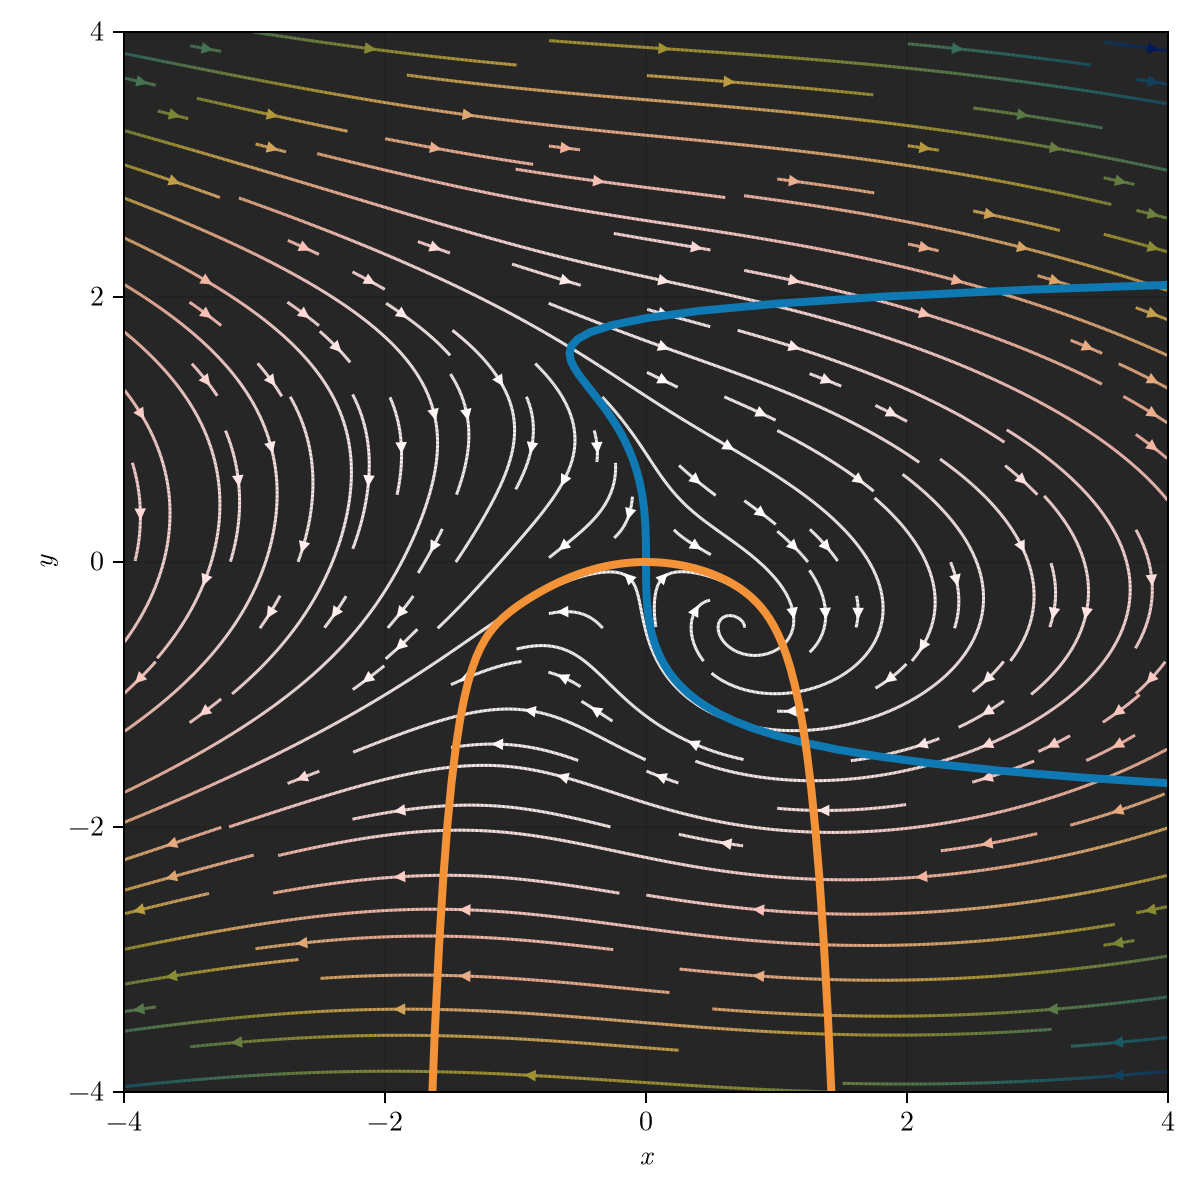

In [23]:
# First time to plot can take a while on Julia...
fig = let
	fig = Figure(size = figsize)
	ax = Axis(fig[1, 1], xlabel = L"x", ylabel = L"y", backgroundcolor = background_color)
	streamplot!(ax, odeSol, (hp[x] - dx) .. (hp[x] + dx), (hp[y] - dy) .. (hp[y] + dy), colormap = colormap,
		gridsize = (32, 32), arrow_size = 8)
	
	# Plot stable manifold
	us_stable = range(hp[x] - 5*dx, hp[x] + 5*dx, length = 750) |> collect
	vs_stable = stab.(us_stable)
	xs_stable, ys_stable = eachrow(P * [us_stable'; vs_stable'] .+ translation)
	lines!(ax, Symbolics.value.(xs_stable), Symbolics.value.(ys_stable), color = color_sable, linewidth = 4, label = L"Stable Manifold $\mathcal{O}\left(u^{%$M}\right)$")
	
	# Plot unstable manifold
	vs_unstable = range(hp[y] - 2*dy, hp[y] + 2*dy, length = 500) |> collect
	us_unstable = ustab.(vs_unstable)
	xs_unstable, ys_unstable = eachrow(P * [us_unstable'; vs_unstable'] .+ translation)
	lines!(ax, Symbolics.value.(xs_unstable), Symbolics.value.(ys_unstable), color = color_unstable, linewidth = 4, label = L"Unstable Manifold $\mathcal{O}\left(v^{%$M}\right)$")
	
	xlims!(ax, hp[x] - dx, hp[x] + dx)
	ylims!(ax, hp[y] - dy, hp[y] + dy)
	# axislegend(ax; position = :rt, backgroundcolor = leg_bg_color)
	fig
end

## Step 9: "Exact" Manifolds via Numerical Integration

To verify our Taylor expansion and see the global structure, we compute the exact manifolds by numerically integrating trajectories that start very close to the hyperbolic point on the local manifolds.

**Method**:
- Start at a point very close to the equilibrium on the stable manifold
- Integrate **backwards** in time (unstable direction becomes stable backwards)
- Start at a point on the unstable manifold
- Integrate **forwards** in time

In [27]:
GC.gc() # Force garbage collection to free memory before heavy numerical integration
# Define the ODE system in ModelingToolkit for numerical integration
@mtkcompile mtk_sys = System(eqs, t)
prob = ODEProblem(mtk_sys, [x => hp[x], y => hp[y]], (0.0, 1.0); jac = true) # Default starting point and time span, we won't use them

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: false
timespan: (0.0, 1.0)
u0: 2-element Vector{Float64}:
 0.0
 0.0

In [28]:
# Numerically integrate trajectories on the exact manifolds

# In this code, type stability should be such that the ODE solvers works in BigFloat, much better than Float64 but slower
sol_stable_left, sol_stable_right, sol_unstable_bottom, sol_unstable_top = let
	δ = 1e-15 # Very small displacement from equilibrium
	alg = Rodas5P()
	solkwargs = (abstol = 1e-15, reltol = 1e-15, saveat = 0.025)
	stable_tspan = (0.0, -125.0)   # Integrate backwards in time
	unstable_tspan = (0.0, 125.0)  # Integrate forwards in time

	# Stable manifold: start at (u, s(u)) with u close to 0
	u_left = -δ
	u_right = δ
	v_left = stab(u_left)
	v_right = stab(u_right)
	xy0_stable_left = P * [u_left, v_left] .+ translation .|> Symbolics.value
	xy0_stable_right = P * [u_right, v_right] .+ translation .|> Symbolics.value

	prob_stable_left = remake(prob, u0 = Dict([x, y] .=> xy0_stable_left))
	prob_stable_right = remake(prob, u0 = Dict([x, y] .=> xy0_stable_right))

	sol_stable_left = solve(prob_stable_left, alg; solkwargs..., tspan = stable_tspan)
	sol_stable_right = solve(prob_stable_right, alg; solkwargs..., tspan = stable_tspan)

	# Unstable manifold: start at (h(v), v) with v close to 0
	v_bottom = -δ
	v_top = δ
	u_bottom = ustab(v_bottom)
	u_top = ustab(v_top)
	xy0_unstable_bottom = P * [u_bottom, v_bottom] .+ translation .|> Symbolics.value
	xy0_unstable_top = P * [u_top, v_top] .+ translation .|> Symbolics.value

	prob_unstable_bottom = remake(prob, u0 = Dict([x, y] .=> xy0_unstable_bottom))
	prob_unstable_top = remake(prob, u0 = Dict([x, y] .=> xy0_unstable_top))

	sol_unstable_bottom = solve(prob_unstable_bottom, alg; solkwargs..., tspan = unstable_tspan)
	sol_unstable_top = solve(prob_unstable_top, alg; solkwargs..., tspan = unstable_tspan)

	(sol_stable_left, sol_stable_right, sol_unstable_bottom, sol_unstable_top)
end;

┌ Warning: At t=-36.27895471553134, dt was forced below floating point epsilon -6.442804356186414e-15, and step error estimate = 1.0096846315550888587144627827738923609124204444955097266452971444917055586372. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of BigFloat).
└ @ SciMLBase /home/lsablon/.julia/packages/SciMLBase/MzuF2/src/integrator_interface.jl:673
┌ Warning: At t=-35.24917160433217, dt was forced below floating point epsilon -6.4086496447157645e-15, and step error estimate = 1.009678298518443576796128177660036677455881091527013364800642483028638460700349. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of BigFloat).
└ @ SciMLBase /home/lsablon/.julia/packages/SciMLBase/MzuF2/src/integrator_interface.jl:673
┌ Warning: At t=35.29995515511625, dt was forced be

## Step 10: Visualization - Exact Manifolds

Finally, we visualize the exact stable and unstable manifolds obtained through numerical integration.

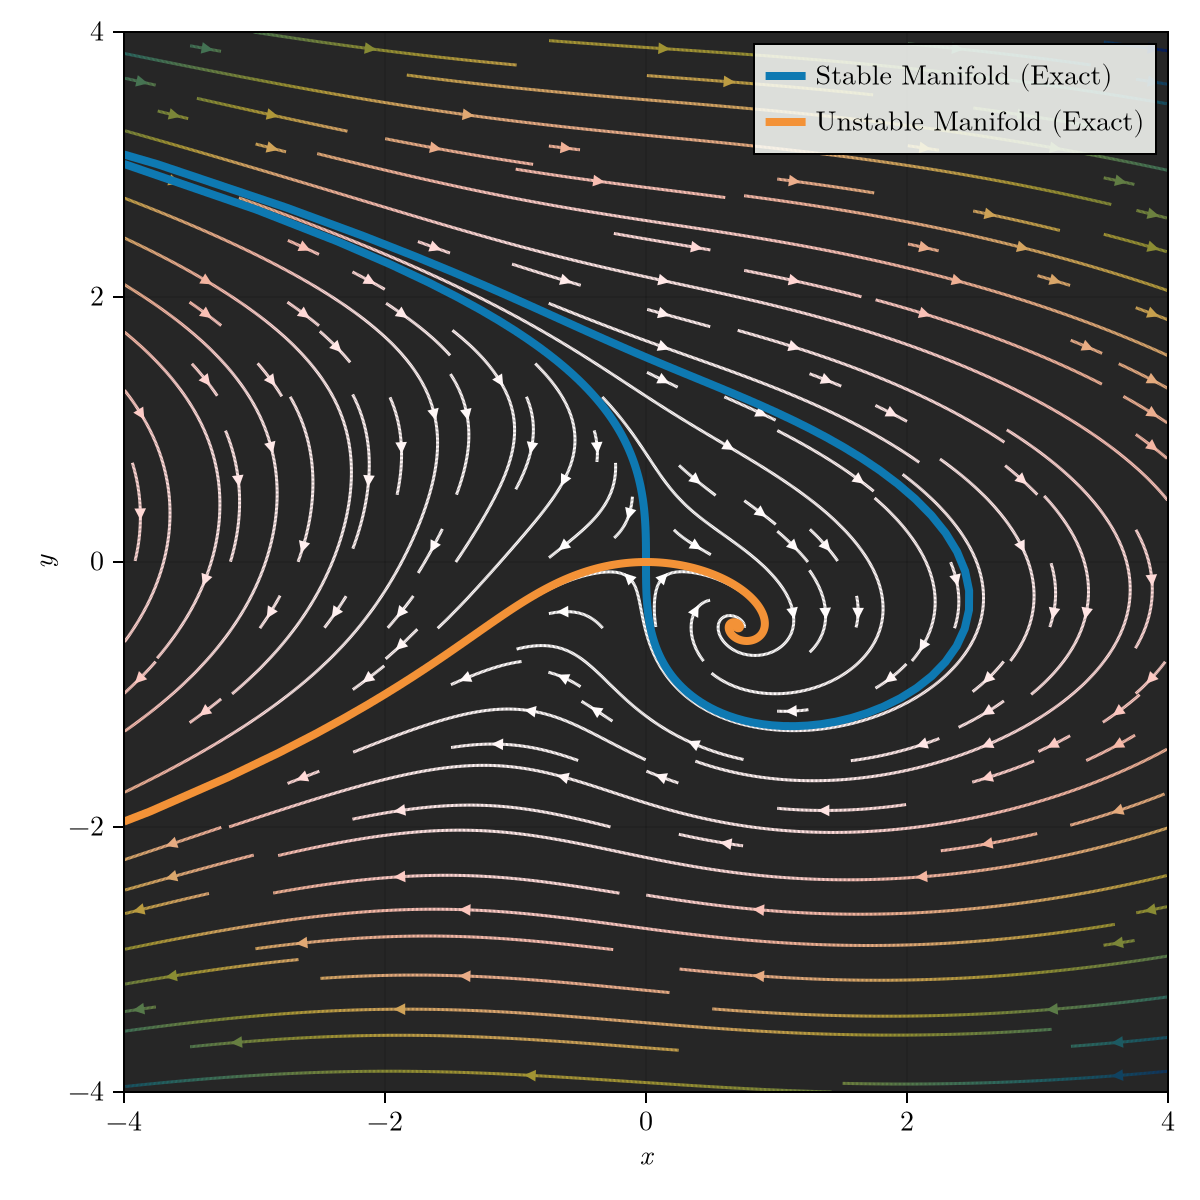

In [29]:
fig_exact = let
	fig = Figure(size = figsize)
	ax = Axis(fig[1, 1], xlabel = L"x", ylabel = L"y", backgroundcolor = background_color)
	streamplot!(ax, odeSol, (hp[x] - dx) .. (hp[x] + dx), (hp[y] - dy) .. (hp[y] + dy), colormap = colormap,
		gridsize = (32, 32), arrow_size = 8)
	
	# Plot stable manifold trajectories
	lines!(ax, sol_stable_left[x, :], sol_stable_left[y, :], color = color_sable, linewidth = 4, label = "Stable Manifold (Exact)")
	lines!(ax, sol_stable_right[x, :], sol_stable_right[y, :], color = color_sable, linewidth = 4)
	
	# Plot unstable manifold trajectories
	lines!(ax, sol_unstable_bottom[x, :], sol_unstable_bottom[y, :], color = color_unstable, linewidth = 4, label = "Unstable Manifold (Exact)")
	lines!(ax, sol_unstable_top[x, :], sol_unstable_top[y, :], color = color_unstable, linewidth = 4)
	
	xlims!(ax, hp[x] - dx, hp[x] + dx)
	ylims!(ax, hp[y] - dy, hp[y] + dy)
	axislegend(ax; position = :rt, backgroundcolor = leg_bg_color)
	fig
end